# LLM Energy Analysis Dashboard

Comprehensive analysis of energy consumption patterns across different LLM models.


In [15]:
# Import libraries for data analysis and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100


In [16]:
# Load and prepare energy consumption data
df = pd.read_json('data/energy.jsonl', lines=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['prompt_length'] = df['prompt'].str.len()
df['response_length'] = df['response'].str.len()
df['energy_per_token'] = df['energy_consumed_wh'] / df['total_tokens']
df['energy_per_char'] = df['energy_consumed_wh'] / df['prompt_length']

print(f"Dataset: {len(df)} records across {df['model'].nunique()} models")
print(f"Models: {', '.join(df['model'].unique())}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")


Dataset: 102 records across 3 models
Models: gpt-4o-mini-2024-07-18, llama-3.1-8b-instant, mistral-large-latest
Date range: 2025-10-19 20:18:09 to 2025-10-19 20:42:52


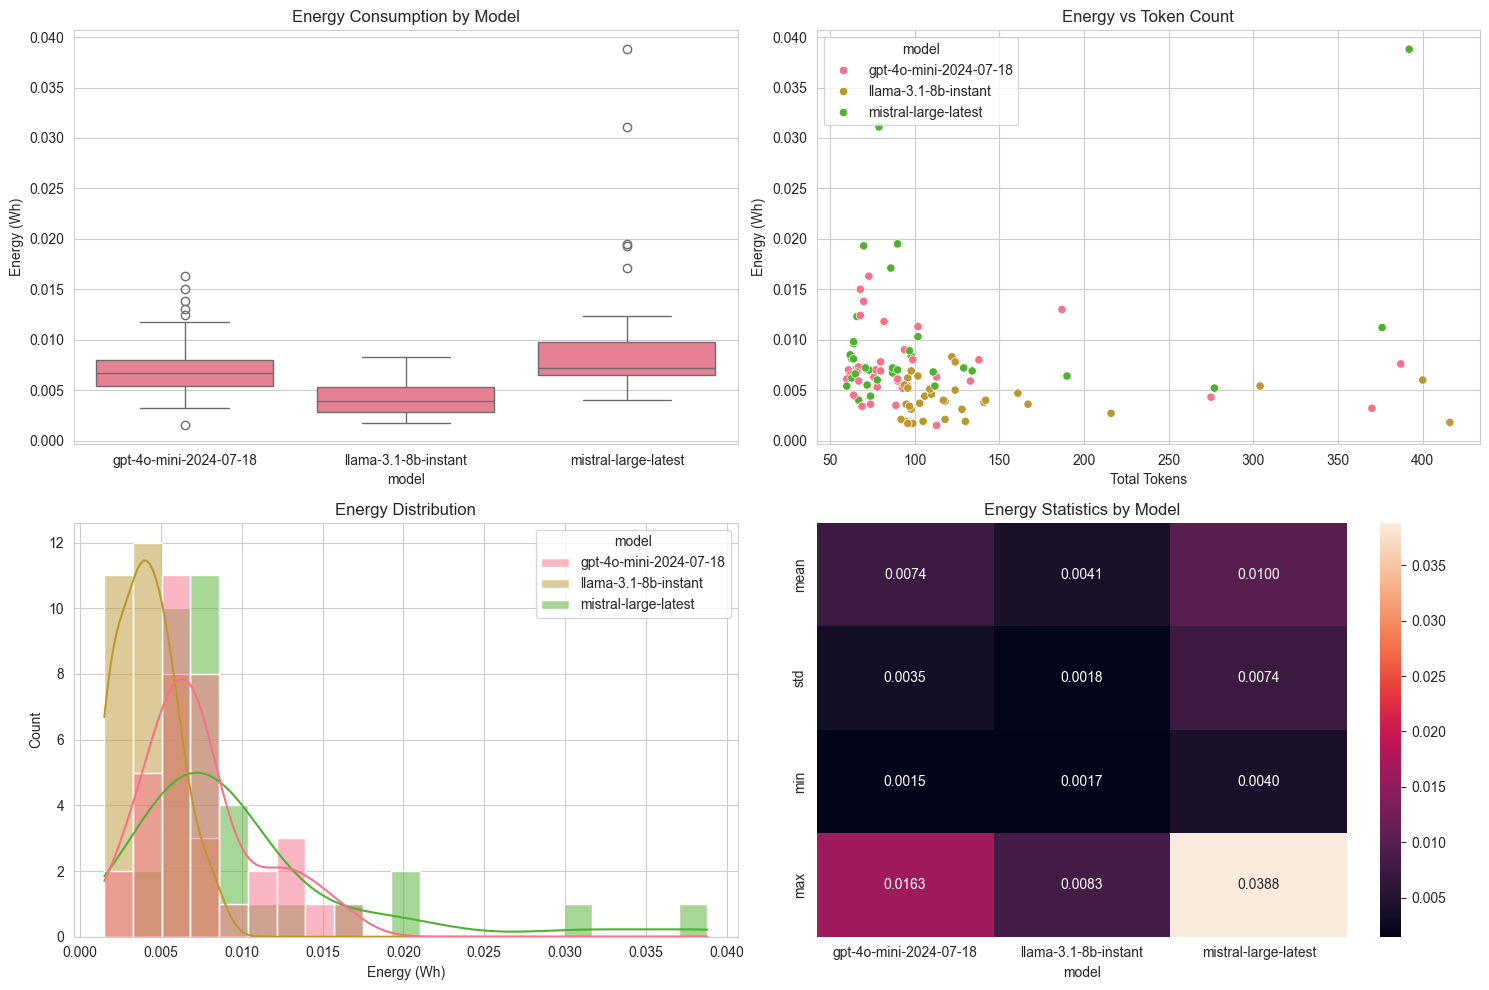

In [17]:
# Energy consumption overview by model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(data=df, x='model', y='energy_consumed_wh', ax=axes[0,0])
axes[0,0].set_title('Energy Consumption by Model')
axes[0,0].set_ylabel('Energy (Wh)')

sns.scatterplot(data=df, x='total_tokens', y='energy_consumed_wh', hue='model', ax=axes[0,1])
axes[0,1].set_title('Energy vs Token Count')
axes[0,1].set_xlabel('Total Tokens')
axes[0,1].set_ylabel('Energy (Wh)')

sns.histplot(data=df, x='energy_consumed_wh', hue='model', kde=True, ax=axes[1,0])
axes[1,0].set_title('Energy Distribution')
axes[1,0].set_xlabel('Energy (Wh)')

energy_summary = df.groupby('model')['energy_consumed_wh'].agg(['mean', 'std', 'min', 'max']).round(4)
sns.heatmap(energy_summary.T, annot=True, fmt='.4f', ax=axes[1,1])
axes[1,1].set_title('Energy Statistics by Model')

plt.tight_layout()
plt.show()


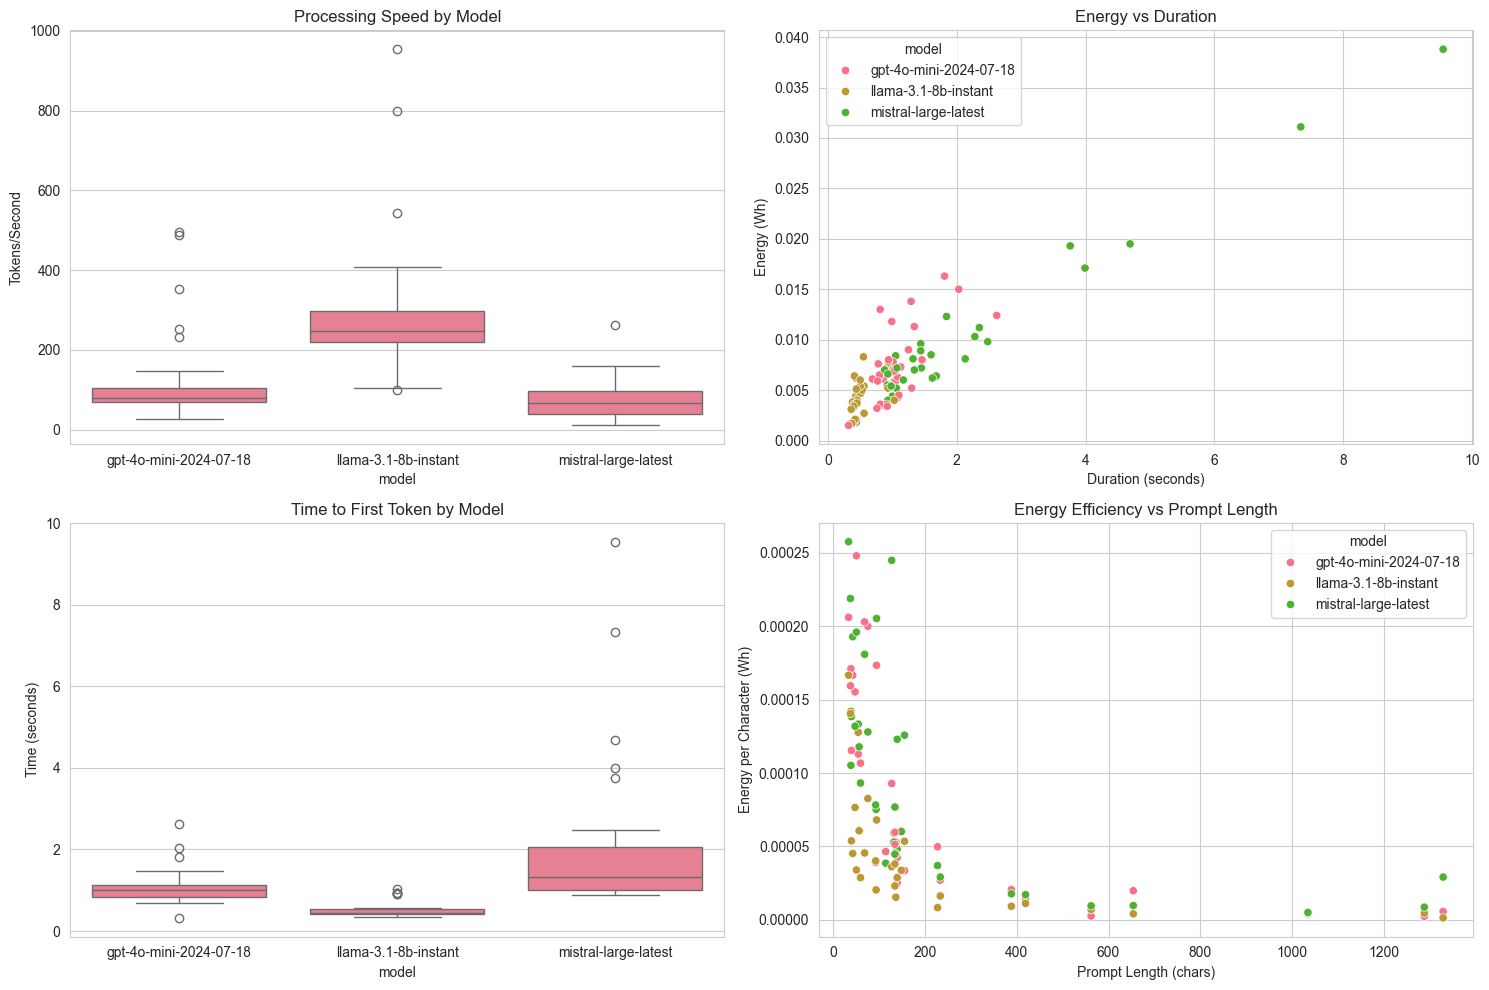

In [18]:
# Performance and efficiency metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(data=df, x='model', y='tokens_per_second', ax=axes[0,0])
axes[0,0].set_title('Processing Speed by Model')
axes[0,0].set_ylabel('Tokens/Second')

sns.scatterplot(data=df, x='duration', y='energy_consumed_wh', hue='model', ax=axes[0,1])
axes[0,1].set_title('Energy vs Duration')
axes[0,1].set_xlabel('Duration (seconds)')
axes[0,1].set_ylabel('Energy (Wh)')

sns.boxplot(data=df, x='model', y='time_to_first_token', ax=axes[1,0])
axes[1,0].set_title('Time to First Token by Model')
axes[1,0].set_ylabel('Time (seconds)')

sns.scatterplot(data=df, x='prompt_length', y='energy_per_char', hue='model', ax=axes[1,1])
axes[1,1].set_title('Energy Efficiency vs Prompt Length')
axes[1,1].set_xlabel('Prompt Length (chars)')
axes[1,1].set_ylabel('Energy per Character (Wh)')

plt.tight_layout()
plt.show()


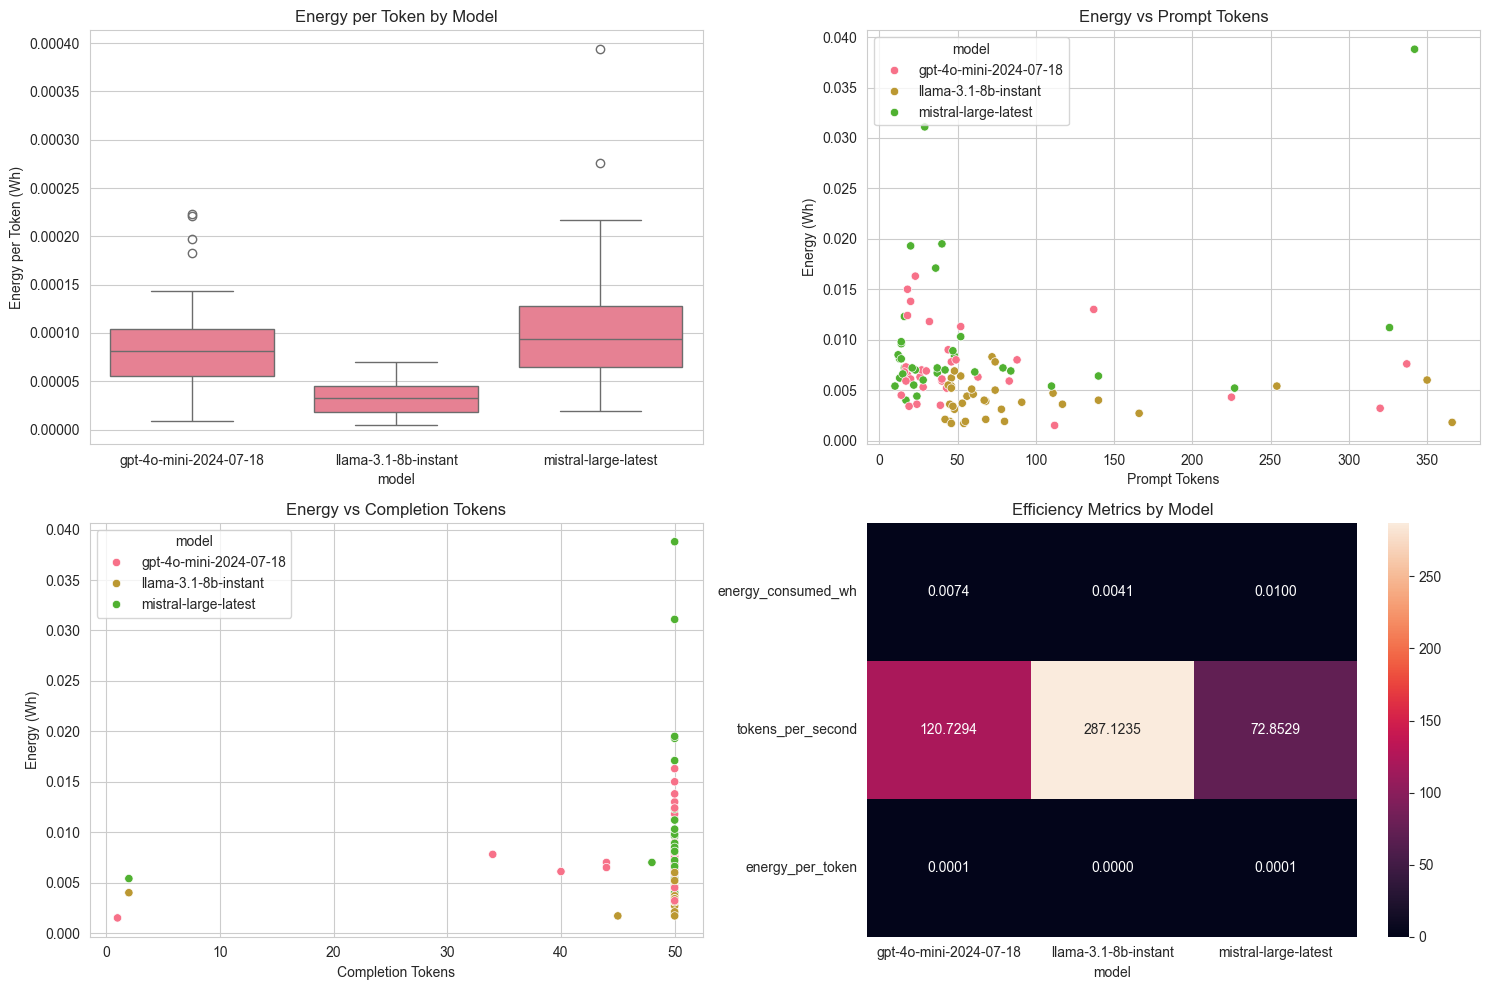

In [19]:
# Energy efficiency analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(data=df, x='model', y='energy_per_token', ax=axes[0,0])
axes[0,0].set_title('Energy per Token by Model')
axes[0,0].set_ylabel('Energy per Token (Wh)')

sns.scatterplot(data=df, x='prompt_tokens', y='energy_consumed_wh', hue='model', ax=axes[0,1])
axes[0,1].set_title('Energy vs Prompt Tokens')
axes[0,1].set_xlabel('Prompt Tokens')
axes[0,1].set_ylabel('Energy (Wh)')

sns.scatterplot(data=df, x='completion_tokens', y='energy_consumed_wh', hue='model', ax=axes[1,0])
axes[1,0].set_title('Energy vs Completion Tokens')
axes[1,0].set_xlabel('Completion Tokens')
axes[1,0].set_ylabel('Energy (Wh)')

efficiency_data = df.groupby('model').agg({
    'energy_consumed_wh': 'mean',
    'tokens_per_second': 'mean',
    'energy_per_token': 'mean'
}).round(4)
sns.heatmap(efficiency_data.T, annot=True, fmt='.4f', ax=axes[1,1])
axes[1,1].set_title('Efficiency Metrics by Model')

plt.tight_layout()
plt.show()


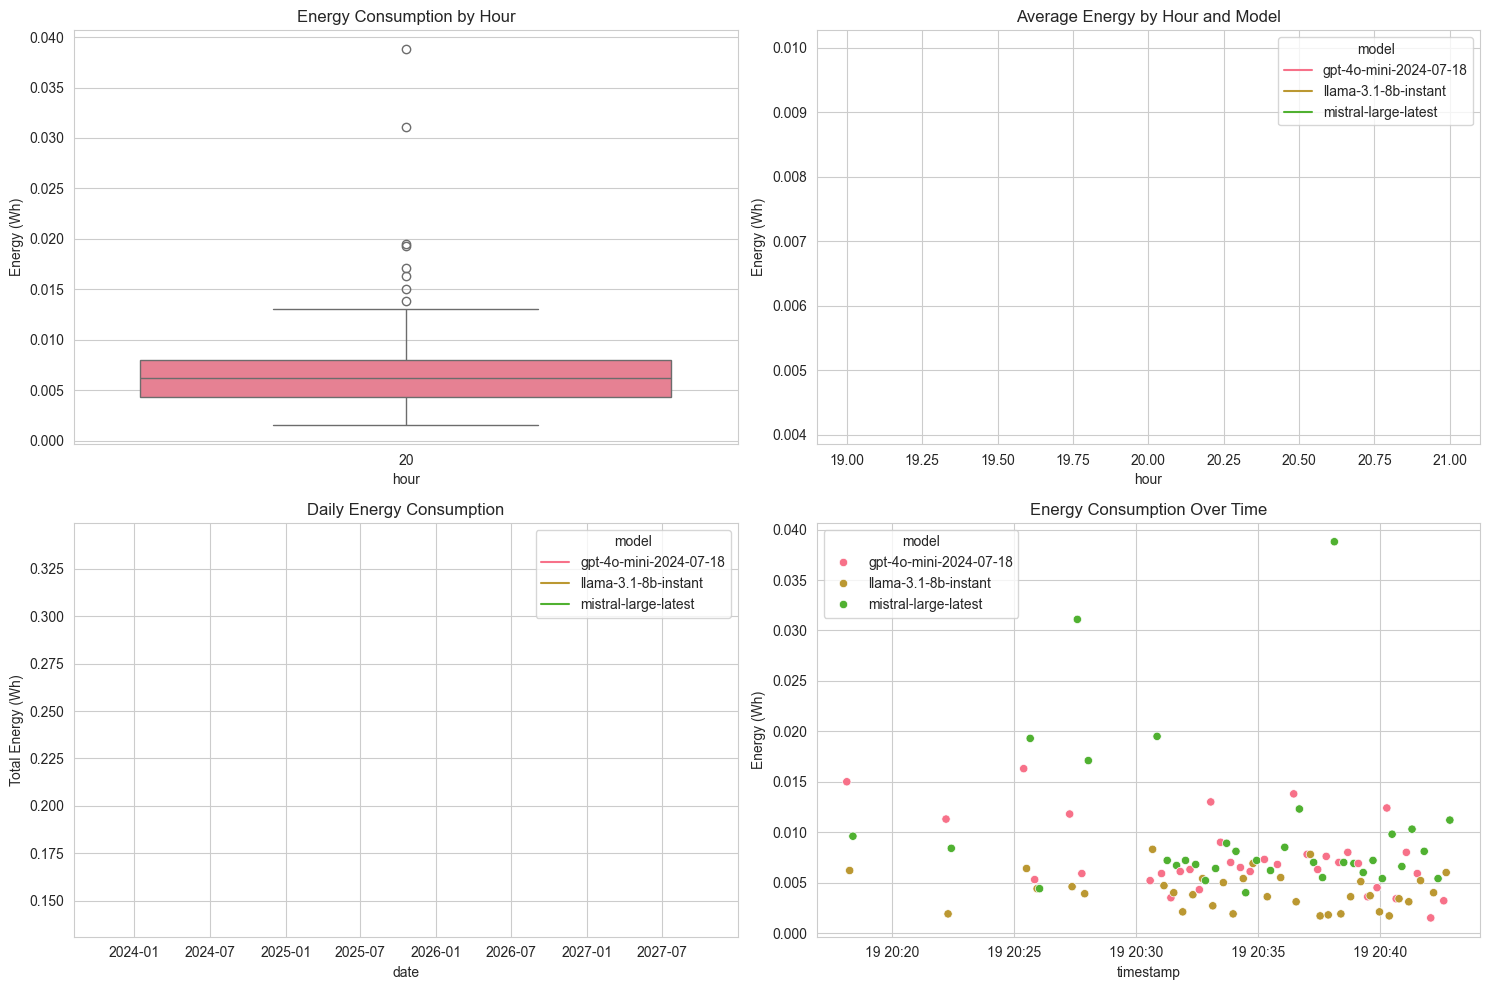

In [20]:
# Temporal patterns in energy consumption
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

df['hour'] = df['timestamp'].dt.hour
sns.boxplot(data=df, x='hour', y='energy_consumed_wh', ax=axes[0,0])
axes[0,0].set_title('Energy Consumption by Hour')
axes[0,0].set_ylabel('Energy (Wh)')

sns.lineplot(data=df.groupby(['model', 'hour'])['energy_consumed_wh'].mean().reset_index(), 
             x='hour', y='energy_consumed_wh', hue='model', ax=axes[0,1])
axes[0,1].set_title('Average Energy by Hour and Model')
axes[0,1].set_ylabel('Energy (Wh)')

df['date'] = df['timestamp'].dt.date
daily_energy = df.groupby(['date', 'model'])['energy_consumed_wh'].sum().reset_index()
sns.lineplot(data=daily_energy, x='date', y='energy_consumed_wh', hue='model', ax=axes[1,0])
axes[1,0].set_title('Daily Energy Consumption')
axes[1,0].set_ylabel('Total Energy (Wh)')

sns.scatterplot(data=df, x='timestamp', y='energy_consumed_wh', hue='model', ax=axes[1,1])
axes[1,1].set_title('Energy Consumption Over Time')
axes[1,1].set_ylabel('Energy (Wh)')

plt.tight_layout()
plt.show()


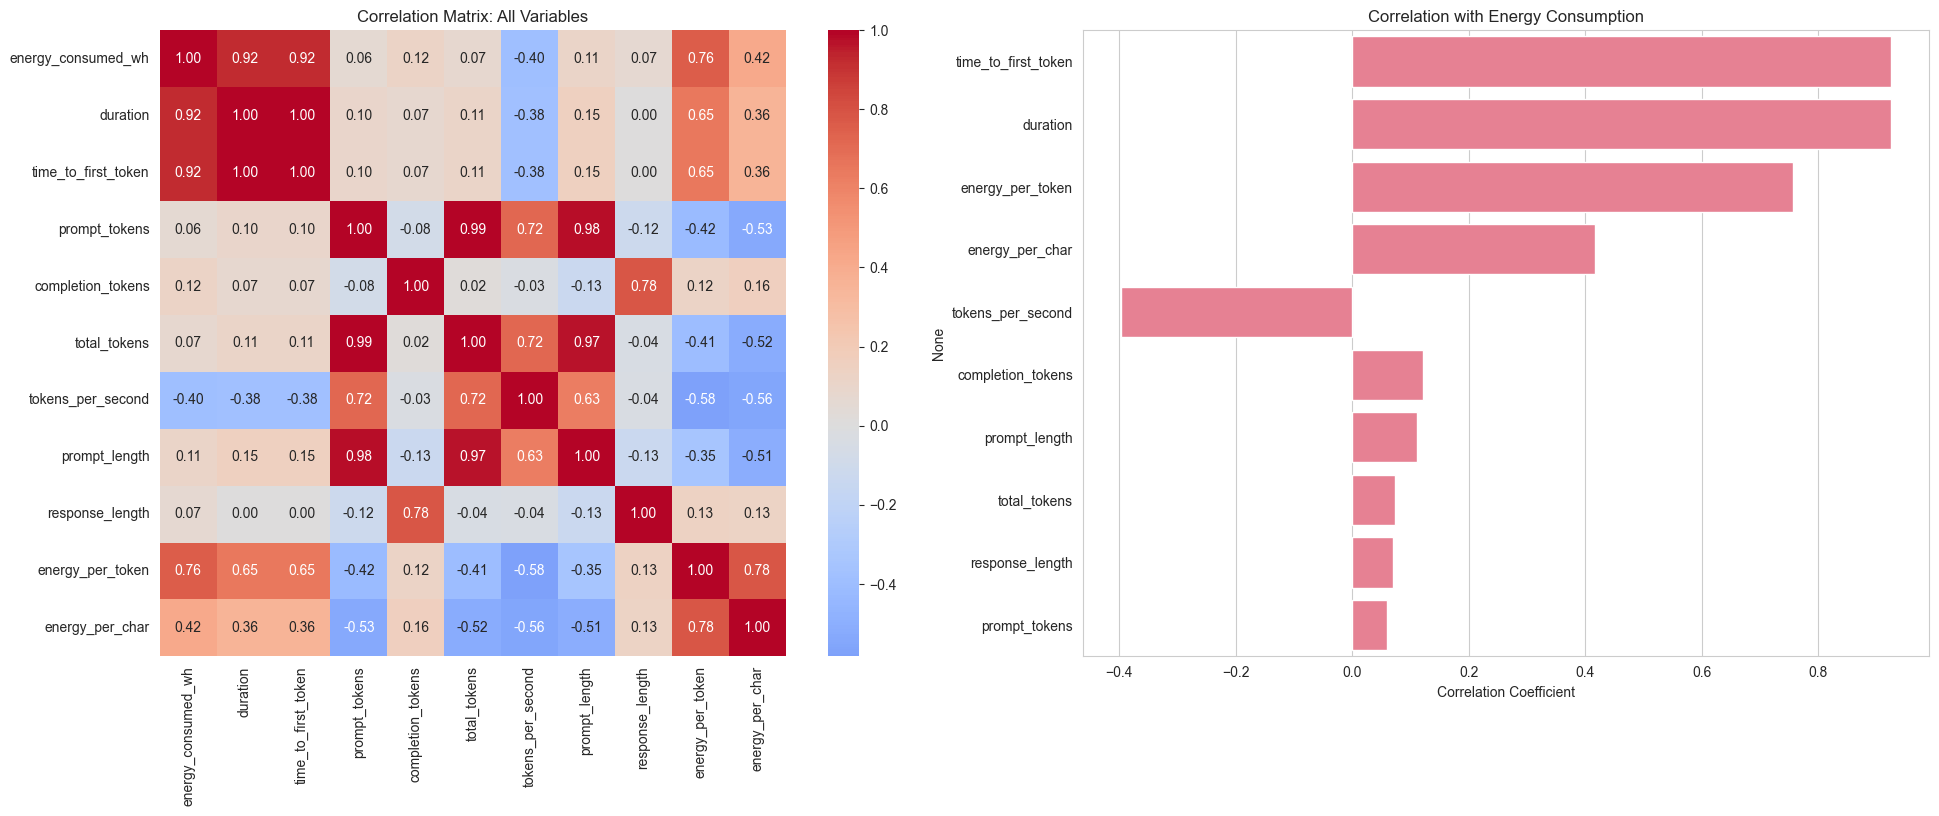

In [21]:
# Correlation analysis between variables
numeric_cols = ['energy_consumed_wh', 'duration', 'time_to_first_token', 
                'prompt_tokens', 'completion_tokens', 'total_tokens', 
                'tokens_per_second', 'prompt_length', 'response_length',
                'energy_per_token', 'energy_per_char']

correlation_matrix = df[numeric_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[0], fmt='.2f')
axes[0].set_title('Correlation Matrix: All Variables')

energy_corr = correlation_matrix['energy_consumed_wh'].drop('energy_consumed_wh').sort_values(key=abs, ascending=False)
sns.barplot(x=energy_corr.values, y=energy_corr.index, ax=axes[1])
axes[1].set_title('Correlation with Energy Consumption')
axes[1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()
